# Handwritten Number Recognition Model (CNN)

## Importing Libraries

In [1]:
!pip install easyocr
!pip install pymupdf
import io
import PIL
import numpy as np
import os
import cv2
import csv

from tensorflow.keras.preprocessing import image #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.datasets import mnist #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input #type:ignore
from tensorflow.keras.callbacks import EarlyStopping #type:ignore
from tensorflow.keras.models import load_model #type:ignore

from google.colab.patches import cv2_imshow #type:ignore
import easyocr
reader = easyocr.Reader(['en'])
import pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 106.9 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

## Importing Dataset

In [2]:
(x_train, y_train) , (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Reshaping

In [3]:
x_train, y_train = x_train.reshape(60000, 28,28,1) , y_train.reshape(60000, 1)
x_test, y_test = x_test.reshape(10000, 28,28,1) , y_test.reshape(10000, 1)

## Normalization

In [4]:
x_train, x_test = x_train/255.0 , x_test/255.0

## Building Model / Train

In [5]:
try:
    model = load_model('model.keras')
except:

    model = Sequential()

    model.add(Input(shape=(28,28,1)))
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))

    model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
    early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(x = x_train , y = y_train, validation_split = 0.2, epochs = 30, batch_size = 1000, callbacks = [early])
    model.save('model.keras')

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.6038 - loss: 1.3592 - val_accuracy: 0.9300 - val_loss: 0.2329
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9325 - loss: 0.2165 - val_accuracy: 0.9638 - val_loss: 0.1285
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9629 - loss: 0.1241 - val_accuracy: 0.9728 - val_loss: 0.0926
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9738 - loss: 0.0863 - val_accuracy: 0.9775 - val_loss: 0.0784
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9781 - loss: 0.0724 - val_accuracy: 0.9800 - val_loss: 0.0652
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9819 - loss: 0.0596 - val_accuracy: 0.9829 - val_loss: 0.0582
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9853 - loss: 0.0521 - val_accuracy: 0.9831 - val_loss: 0.0568
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9874 - loss: 0.0467 - val_accuracy: 0.9852 - 

In [6]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9845 - loss: 0.0463


[0.036394279450178146, 0.9879000186920166]

# OCR/ CNN function

## CNN

In [7]:
def hand_prediction(img_obj):
    image = img_obj
    def remove_borders(image, border_size=5):
        # Crop out the borders by a fixed size
        return image[border_size:-border_size, border_size:-border_size]
    # Remove borders from the entire image
    image = remove_borders(image, border_size=5)

    image = cv2.cvtColor(image, cv2. COLOR_BGR2GRAY)

    # Apply binary thresholding to the image
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by their x position
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    digits = []

    global num
    global probability
    global n
    num = 0

    for ctr in contours:
        num = num*10
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(ctr)

        # Add padding to the bounding box
        padding = 5  # Adjust padding as needed
        x = max(x - padding, 0)
        y = max(y - padding, 0)
        w = min(w + 2 * padding, image.shape[1] - x)
        h = min(h + 2 * padding, image.shape[0] - y)

        # Extract the digit using the bounding box
        digit = thresh[y:y+h, x:x+w]
        # Resizing to fit model input
        resized_digit = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)
        # Normalization
        digit = resized_digit / 255.0
        r = model.predict(digit.reshape(1,28,28,1))

        if np.max(r) < 0.95:

            cv2_imshow(np.reshape((digit*255), (28,28,1)))
            print(f"Predicted:{np.argmax(r)} ({round(np.max(r)*100,2)})")
            print("Actual:")
            n = int(input())
            digit = digit.reshape(1,28,28,1)
            model.fit(digit, np.array([[n]]))
            model.save('model.keras')
            num = num + n
        else:
            num = num + np.argmax(r)
            print(np.max(r))


    return [num]

## OCR

In [8]:
def ocr_prediction(img_obj):
    try:
        results = reader.readtext(img_obj)
        result_set = set()
        if len(results) > 1:
            for x in results[0][1]:
                result_set.add(x)
            for x in results[1][1]:
                result_set.add(x)

        if results:
            return results
        else:
            return 'ERR'
    except Exception as e:
        return 'ERR'

## ALL PAGES
Now for all pages, we cascadingly call all functions, in a for loop


In [9]:
def read_pdf(pdf_path):
    pdf_document = pymupdf.open(pdf_path)
    global rows_written
    rows_written = 0

    if not os.path.exists('outputs'):
        os.makedirs('outputs')


    #Clearing any past file
    with open('outputs/output.csv', mode='w') as csv_file:
        csv_writer = csv.writer(csv_file)

    with open('outputs/attention.txt', mode='w') as txt_file:
        txt_write = txt_file.write('')

    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        # To image (using matrix transformation)
        zoom = 2  # Adjust zoom level as needed
        mat = pymupdf.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat, alpha=False)

        # pixmap to PIL Image
        img_bytes = pix.tobytes("ppm")
        image = PIL.Image.open(io.BytesIO(img_bytes))

        image = np.array(image)

        #return image

        #instead lets read all pages

        table = get_table(image, page_number)

In [10]:
def get_table(image, page_number):
    ## Filters
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)


    ## Contour detection
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
    table_contour = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        if len(approx) == 4:
            table_contour = approx
            break

    if table_contour is not None:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(table_contour)

        # Crop the table region from the original image
        table_image = image[y:y+h, x:x+w]
        num_rows = 0

        #return table_image

        extract_cells_to_csv(table_image, page_number)

    else:
        print("error")

In [11]:
def extract_cells_to_csv(image, page_number, csv_filename='outputs/output.csv'):

    # Determine number of rows using page height
    # height = 181 + 59*rows
    height = len(image)
    num_rows = round((height - 181) / 59)
    global rows_written

    # Parameters (adjust these values as needed)
    title_offset = 106 + (num_rows * 2)  # Offset to skip the title
    header_row_height = 75  # Height of the header row
    row_height = 57  # Height of each subsequent row

    # Column widths (adjust these values according to your table)
    col_names = ["SNo.","ID","NAME","DOB","INTERVIEW MARKS"]
    column_widths = [67, 73, 392 + (num_rows * 2), 175, 380]

    # Function to get the column boundaries
    def get_column_boundaries(column_widths):
        boundaries = [0]
        for width in column_widths:
            boundaries.append(boundaries[-1] + width)
        return boundaries

    column_boundaries = get_column_boundaries(column_widths)

    # Open a CSV file to write the results
    with open(csv_filename, mode='a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        if page_number == 0:
          # Extract header row
          header_row = image[title_offset:title_offset + header_row_height, :]
          header_cells = []

          # Process each cell of the header row
          for col in range(0,5):
              cell = header_row[:, column_boundaries[col]:column_boundaries[col + 1]]
              cell_image = np.array(cell)
              header_cells.append(ocr_prediction(cell_image)[0][1])

          # Write the header row to the CSV
          csv_writer.writerow(header_cells)

        # Extract subsequent rows
        for row in range(1, num_rows + 1):
            row_start = title_offset + header_row_height + (row - 1) * row_height
            row_end = row_start + row_height
            table_row = image[row_start:row_end, :]
            row_cells = []

            # Process each cell of the row
            row_cells.append(f'{row + rows_written}')
            for col in range(1,5):
                cell = table_row[:, column_boundaries[col]:column_boundaries[col + 1]]
                cell_image = np.array(cell)
                if col < 4:

                   if len(ocr_prediction(cell_image)) > 1:
                       cv2_imshow(cell_image)
                       print(f"PREDICTION:{ocr_prediction(cell_image)[0][1]}")
                       print("ACTUAL:")
                       n = str(input())
                       row_cells.append(n)
                   else:
                      row_cells.append(ocr_prediction(cell_image)[0][1])

                if col == 4:
                    r = hand_prediction(cell_image)
                    row_cells.append(r[0])

            # Write the row to the CSV
            csv_writer.writerow(row_cells)

    print(f"Written {num_rows} row(s) to '{csv_filename}'.")
    rows_written += num_rows

ADDING PROBABILITY BASED WARNING FOR CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.99996924
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.99999595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.9999949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9525418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.9979323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.9999881
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9998735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.9999001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.9991285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.9978662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.9963718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.998197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.999074


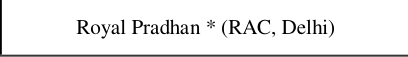

PREDICTION:Royal Pradhan
ACTUAL:
Royal Pradhan * (RAC, Delhi)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.9997889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9996296
Written 8 row(s) to 'outputs/output.csv'.


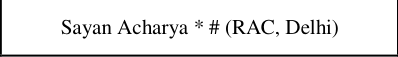

PREDICTION:Acharya
ACTUAL:
Sayan Acharya *# (RAC, Delhi)
Written 3 row(s) to 'outputs/output.csv'.


In [13]:
read_pdf("pdf-marked-demo.pdf")